  0%|          | 0/1 [00:00<?, ?it/s]

Max-Min of load image:  254 0
Laplacian level:  0
Shape:  (256, 256)
Max-Min:  0.35095334520526966 -0.33796458524816175
Laplacian level:  1
Shape:  (128, 128)
Max-Min:  0.9730507046568627 0.006426164215686274
Laplacian highest f:  0.35095334520526966 -0.33796458524816175
Laplacian highest f:  216.99310302734375 41.31903076171875
(256, 256, 3)


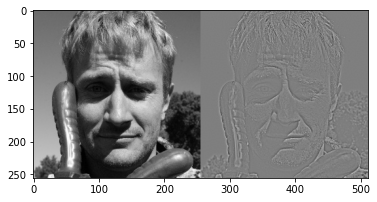

100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import tqdm
import os, glob

set_ = 'valid'
img_file = glob.glob(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/*.jpg")
img_file = [f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/60065.jpg"]
img_size = 256
import cv2
from PIL import Image
import blobfile as bf

lap_out = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/laplacian/{set_}/"
os.makedirs(lap_out, exist_ok=True)

def create_gaussian_pyramid(img, level=5):
    pys = [img]
    for i in range(level-1):
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)), interpolation=cv2.INTER_AREA)
        pys.append(img)
    return pys

def create_laplacian_pyramid(img, level=2):
    pys = create_gaussian_pyramid(img, level)
    for i in range(level-1):
        pys[i] = pys[i] - cv2.resize(pys[i+1], (pys[i].shape[1], pys[i].shape[0]))
    return pys

mode = 'L'
for i, path in enumerate(tqdm.tqdm(img_file)):
    name = path.split('/')[-1].split('.')[0]
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert(mode)
    # pil_image = pil_image.convert("RGB")
    print("Max-Min of load image: ", np.max(np.array(pil_image)), np.min(np.array(pil_image)))
    img = np.array(pil_image) / 255
    img_lap = create_laplacian_pyramid(img)
    highest_freq_img = img_lap[0]
    # np.save(file=f"{lap_out}/{name}.npy", arr=highest_freq_img, )
    if i == 10: break
    for j in range(0, len(img_lap)):
        print("Laplacian level: ", j)
        print("Shape: ", img_lap[j].shape)
        print("Max-Min: ", np.max(img_lap[j]), np.min(img_lap[j]))
    print("Laplacian highest f: ", np.max(img_lap[0]), np.min(img_lap[0]))
    highest_freq_img = (img_lap[0] + 0.5) * 255
    print("Laplacian highest f: ", np.max(highest_freq_img), np.min(highest_freq_img))
    if mode == 'L':
        highest_freq_img = np.repeat(highest_freq_img[:, :, np.newaxis], 3, axis=2)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        print(highest_freq_img.shape)
    plt.imshow(np.concatenate(((img*255).astype(np.uint8), highest_freq_img.astype(np.uint8)), 1))
    plt.show()
    # Plot all levels of laplacian
    # for j in range(0, len(img_lap)):
    #     tmp = (img_lap[j] + 0.5) * 255
    #     plt.imshow(np.repeat(tmp[:, :, np.newaxis], 3, axis=2).astype(np.uint8))
    #     plt.show()
    